In [2]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1

     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 421.8MB 19kB/s 
     |████████████████████████████████| 3.9MB 42.4MB/s 
     |████████████████████████████████| 450kB 42.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=e2614dcc2443c5fcb5f3de9eb691257e018194945f76ce96e82689e026b13b25
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tens

In [ ]:
#For live loss function updates
#!pip install livelossplot

In [3]:
%matplotlib inline

In [4]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [5]:
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [10]:
#print(os.listdir("membrane/train"))

#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/content/drive/My Drive/Colab Notebooks/data/membrane/train/image"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/content/drive/My Drive/Colab Notebooks/data/membrane/train/label"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)


In [11]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)


In [12]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

print(model.summary())


85524480/85521592 [==============================] - 2s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
___________________________

In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
#from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training (callbacks=[PlotLossesKeras()],)
model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=2000,
   verbose=1,
   validation_data=(x_val, y_val),
)

#accuracy = model.evaluate(x_val, y_val)


In [24]:
model.save('/content/drive/My Drive/Colab Notebooks/data/membrane3000.h5')

In [25]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/data/membrane3000.h5', compile=False)

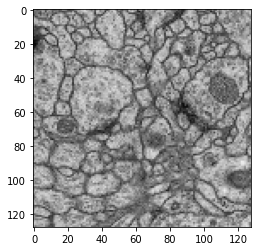

In [28]:

#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/drive/My Drive/Colab Notebooks/data/membrane/train/image/0.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)





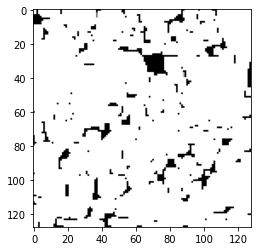

In [29]:
#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
#plt.imsave('images/test_images/segmented.jpg', prediction_image, cmap='gray')
